In [9]:
import numpy as np
from scipy.special import lambertw

from rikabplotlib.plot_utils import newplot, hist_with_errors, hist_with_outline

In [10]:
E0 = 500

beta = 1
R = 0.5

def alpha_s(scale):
    lambda_qcd = 0.2
    beta_0 = 11 - 2/3 * 3
    return 4 * np.pi / (beta_0 * np.log(scale**2 / lambda_qcd**2))

def LO_angularity(lambda_):

    scale = E0 * np.power(lambda_, 1 / (beta))

    alpha_s_scale = alpha_s(scale)
    C_F = 4/3
    C_A = 3

    return -(2 * alpha_s_scale * C_F / (1 * np.pi * beta * R)) * np.log(lambda_ ) / lambda_ 




In [11]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def p_x(x):
    return -np.log(x) / x

p_x = LO_angularity

def C(x, c = 0.5, temp = 0.001):

    return sigmoid((x - c) / temp) - sigmoid((0 - c) / temp)



def ReLU(x):
    return np.maximum(0, x)

N_samples = 100000
x = np.random.uniform(0, 1, N_samples)

def answer(p, C, x, lambda_ = None, c = 0.5):

    # log MSE
    arg = lambda_ * p(x) / (2 * C(x, c) )
    q = p(x) * np.exp(lambertw(-arg))
    return(q)

    # ratio MSE
    return ReLU(p(x) - p(x)**2 * lambda_ / (2 * C(x, c)))


def integral(p, C, x, lambda_ = None, c = 0.5):

    ans = answer(p, C, x, lambda_, c)
    return np.mean(ans)

def find_lambda(c = 0.5):

    tolerance = 1e-5

    max_lambda = 2 * C(x, c) * p_x(x)

    # Take the minimum of the max_lambda
    max_lambda = np.max(max_lambda) 
    min_lambda = - max_lambda

    s_max = integral(p_x, C, x, max_lambda, c)
    s_min = integral(p_x, C, x, min_lambda, c)

    mid_lambda = (max_lambda + min_lambda) / 2 
    s_mid = integral(p_x, C, x, mid_lambda, c)

    while np.abs(s_mid - 1) > tolerance:
        if s_mid > 1:
            min_lambda = mid_lambda
        else:
            max_lambda = mid_lambda

        mid_lambda = (max_lambda + min_lambda) / 2
        s_mid = integral(p_x, C, x, mid_lambda, c)

    return mid_lambda


In [12]:
print(np.sort(x))

[1.63937802e-06 1.26736098e-05 1.94846030e-05 ... 9.99943465e-01
 9.99943626e-01 9.99971512e-01]


/tmp/ipykernel_41882/779398208.py:2: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))


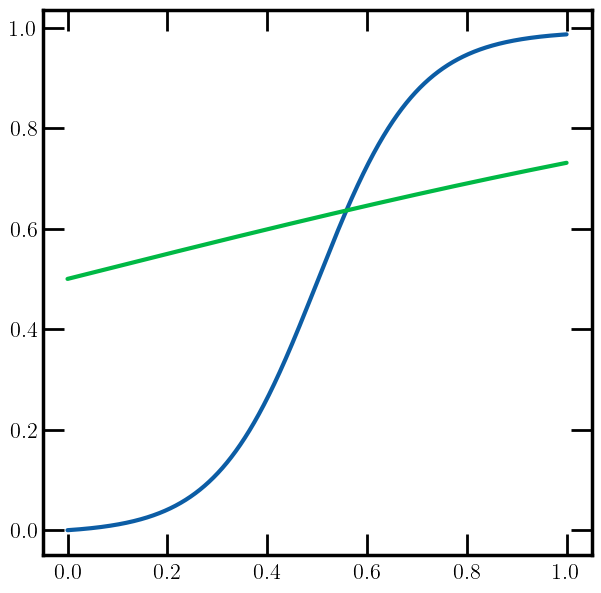

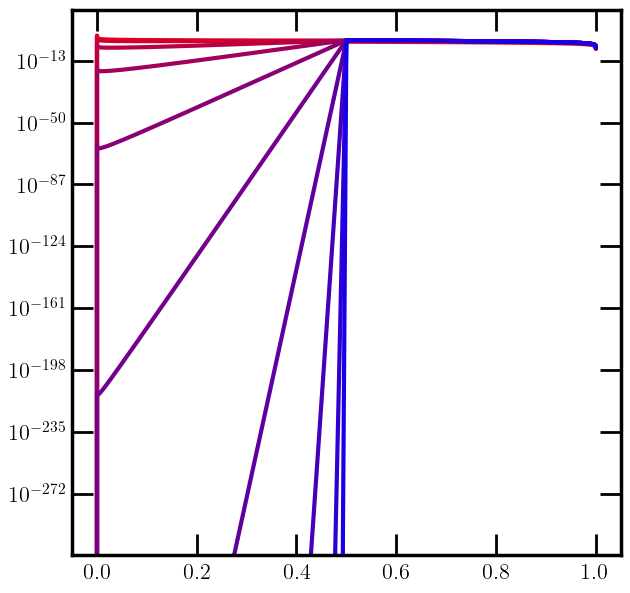

In [13]:
fig, ax = newplot("full")
x_sorted = np.sort(x)
ax.plot(x_sorted, C(x_sorted), label = "C(x)")
ax.plot(x_sorted, sigmoid(x_sorted), label = "p(x)")
# ax.plot(x_sorted, p_x(x_sorted), label = "p(x)")


fig, ax = newplot("full")
for (i,temp) in enumerate(np.logspace(-5, 0, 11)[::-1]):

    # warm to cool color
    n = 11
    color = (1 - i/n, 0, i/n)
   
    ratio = p_x(x_sorted) * C(x_sorted, temp=temp)
    ax.plot(x_sorted, ratio, label = "p(x) / C(x)", color = color)
    ax.set_yscale("log")
    # ax.set_xscale("log")

/tmp/ipykernel_41882/1778562690.py:10: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet")


KeyboardInterrupt: 

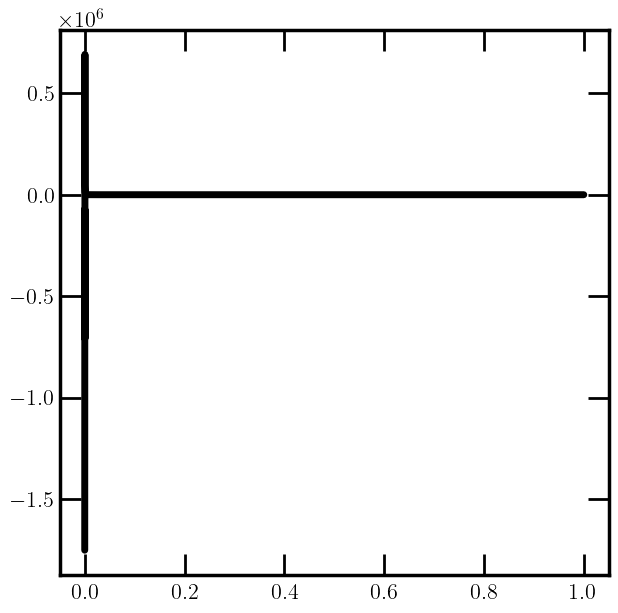

In [14]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap

fig, ax = newplot("full")

ax.plot(x_sorted, p_x(x_sorted), label = "p(x)", color = "black", lw = 5)


cs = np.linspace(0, 1.0, 21)[::-1]
colors = get_cmap("jet")

for c in cs:




    lambda_ = find_lambda(c)
    ax.plot(x_sorted + c / 100, answer(p_x, C, x_sorted, lambda_, c), label = "answer", color = colors(1-c), alpha = 0.9, lw = 2)


    ax.set_yscale("log")
# print(answer(p_x, C, x_sorted, lambda_, c))
    print(c, integral(p_x, C, x, lambda_, c))

ax.set_ylim(1e-3, 1e3)

In [20]:
c = 0.5
lambda_ = find_lambda(c)
a = (answer(p_x, C, x_sorted, lambda_, c))
print(c, integral(p_x, C, x, lambda_, c))
print(a)

0.5 1.0000075129718808
[0.00000000e+00 0.00000000e+00 0.00000000e+00 ... 3.27569911e-06
 2.89686818e-06 6.49049196e-07]


/tmp/ipykernel_17563/1493205528.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = get_cmap("jet")


0.0 1.0000025657663032
0.05 1.0000075358348288
0.1 0.9999990641691424
0.15000000000000002 0.9999975577156304
0.2 1.0000074380969441
0.25 0.9999944887215896
0.30000000000000004 0.9999959228853229
0.35000000000000003 1.000002859990671
0.4 1.000007845529895
0.45 0.9999978190117795


KeyboardInterrupt: 

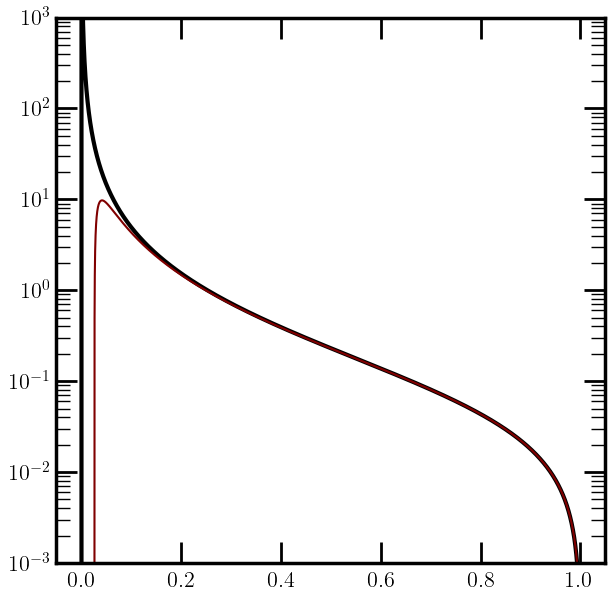

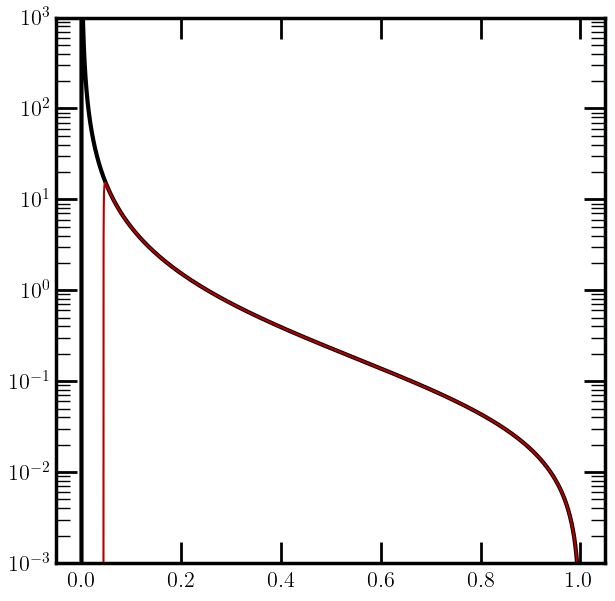

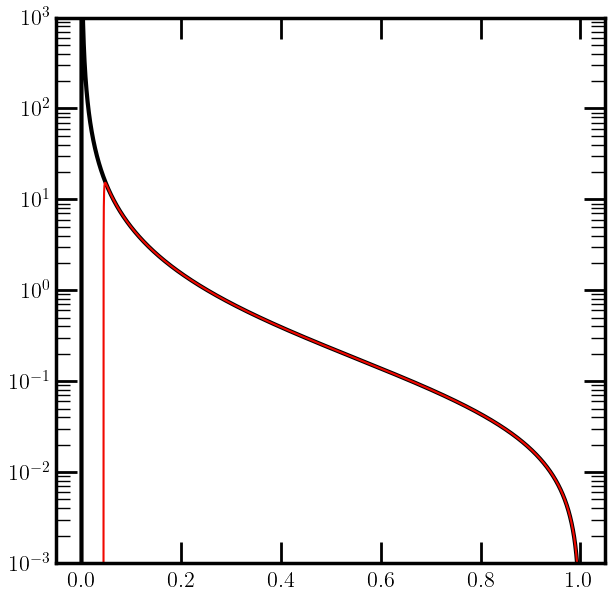

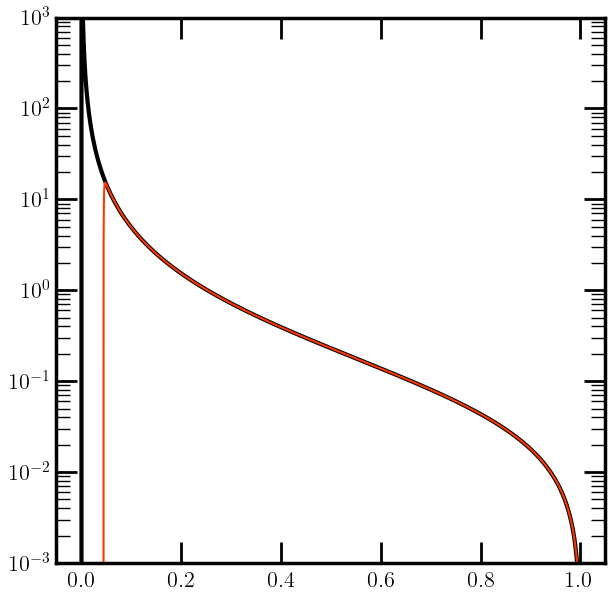

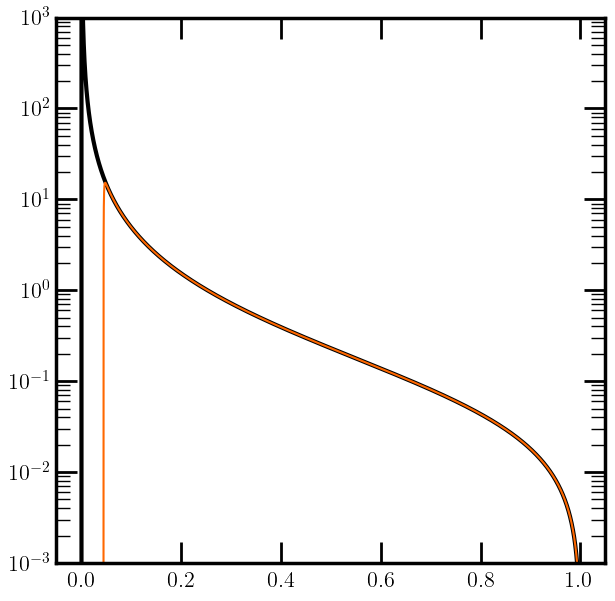

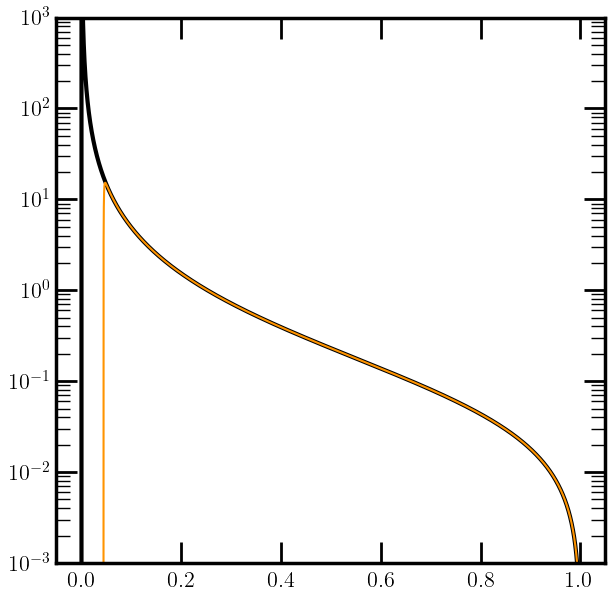

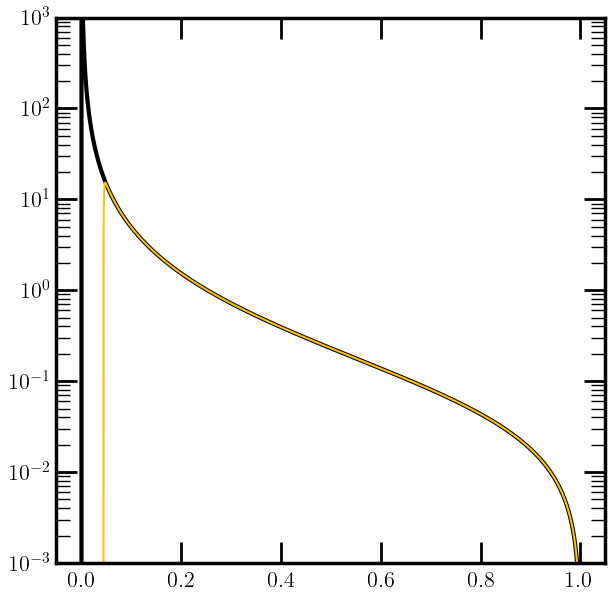

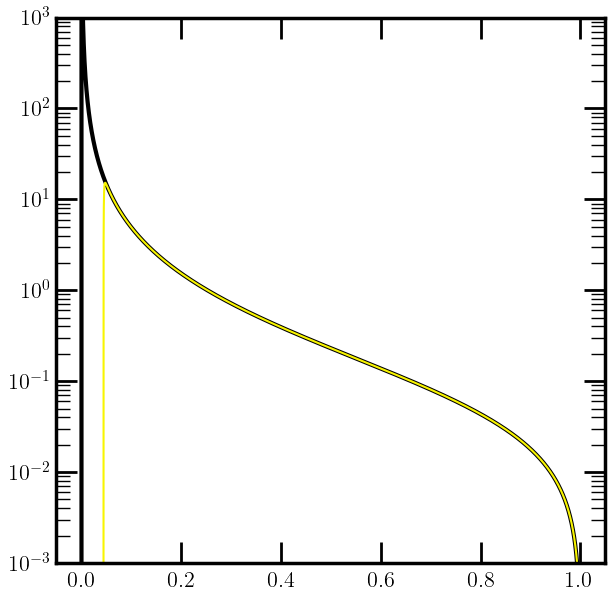

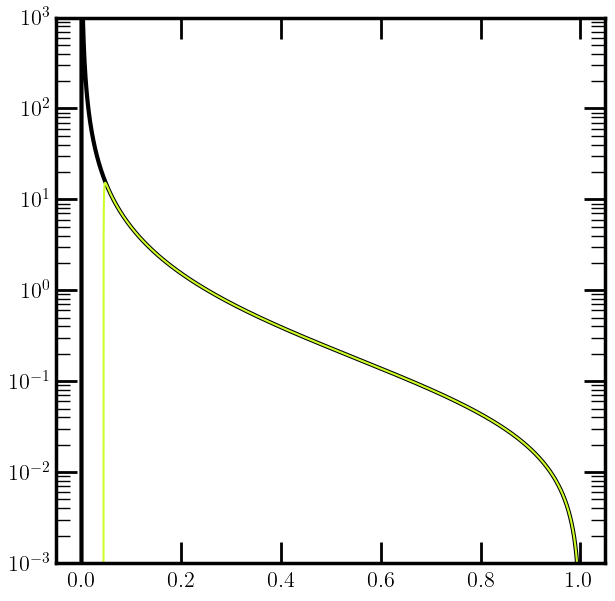

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap


cs = np.linspace(0, 1.0, 21)
colors = get_cmap("jet")

for c in cs:

    fig, ax = newplot("full")

    ax.plot(x_sorted, p_x(x_sorted), label = "p(x)", color = "black", lw = 3)




    lambda_ = find_lambda(c)
    ax.plot(x_sorted, answer(p_x, C, x_sorted, lambda_, c), label = "answer", color = colors(1-c), alpha = 1, lw = 1.5)


    ax.set_yscale("log")
# print(answer(p_x, C, x_sorted, lambda_, c))
    print(c, integral(p_x, C, x, lambda_, c))

    ax.set_ylim(1e-3, 1e3)